In [1]:
import numpy

from numpy import random
from matplotlib import pyplot
from scipy import stats

_BASE_SEED = """This is a pretty long string. I am making some odd decisions with it?
Who shall say this is not a pretty entropic thing I'm rwriting, I tell you hwaht."""

In [2]:
def seed(s: str) -> int:
    return abs(hash(_BASE_SEED + s)) % (2 ** 32)

## 5.1, Discrete probability simulation

> Suppose that a basketball player has a 60% chance of making a shot, and he
> keeps taking shots until he misses two in a row. Also assume his shots are
> independent (so that each shot has 60% probability of success, no matter what
> happened before).
>
> (a) Write an R function to simulate this process.
>
> (b) Put the R function in a loop to simulate the process 1000 times. Use the
> simulation to estimate the mean and standard deviation of the total number of
> shots that the player will take, and plot a histogram representing the
> distribution of this random variable.
>
> (c) Using your simulations, make a scatterplot of the number of shots the
> player will take and the proportion of shots that are successes.

In [3]:
rng = random.default_rng(seed=seed('Example 5.1'))

Start with a manual implementation, just to satisfy the spirit of the problem:

In [4]:
def manual_implementation() -> int:
    misses = 0
    shots = 0
    while misses < 2:
        shots += 1
        if rng.random() > 0.6:
            misses += 1
    return shots    

In [5]:
manual_simulations = [manual_implementation() for _ in range(1000)]
print(f'Mean:     {numpy.mean(manual_simulations):0.2f}\nStd. Dev: {numpy.std(manual_simulations):0.2f}')

Mean:     4.96
Std. Dev: 2.66


In [6]:
def histogram_basketball(shot_counts: list[int]):
    fig = pyplot.figure(figsize=(7, 5))
    ax = fig.gca()
    ax.hist(shot_counts, bins=max(shot_counts), range=(0, max(shot_counts)),
            align='left')
    ax.set_xlabel('Number of shots')
    ax.set_ylabel('Number of simulations')
    ax.set_xticks(range(0, 1 + max(shot_counts)))
    ax.set_xlim(0, 1 + max(shot_counts))
    ax.grid()

In [7]:
def scatter_basketball(shot_counts: list[int]):
    # Add some jitter to the shot counts:
    xs = [rng.uniform(-0.15, 0.15) + count for count in shot_counts]
    # And also to the proportion:
    ys = [rng.uniform(-0.02, 0.02) + float(count - 2) / count for count in shot_counts]
    fig = pyplot.figure(figsize=(7, 5))
    ax = fig.gca()
    ax.set_xlabel('Shots taken')
    ax.set_ylabel('Success rate')
    ax.scatter(xs, ys, s=2, alpha=0.8)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(-0.5, max(shot_counts) + 0.5)
    ax.set_xticks([xi for xi in range(max(shot_counts) + 1) if xi % 3 == 0])
    ax.grid()

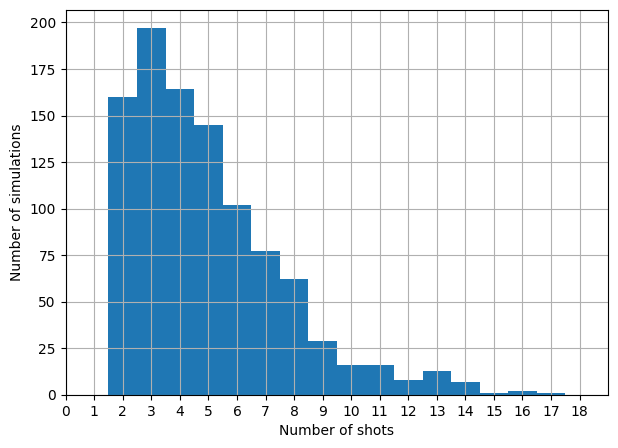

In [8]:
histogram_basketball(manual_simulations)

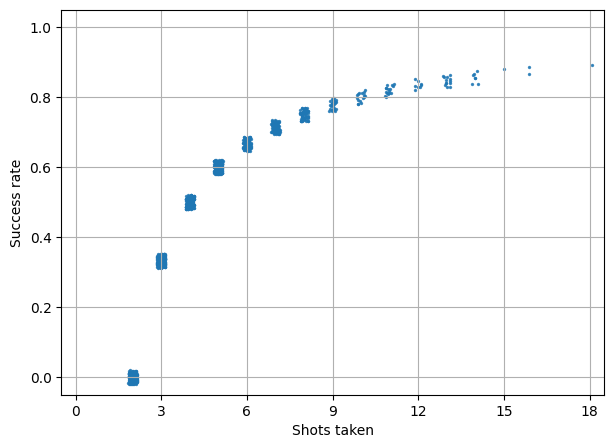

In [9]:
scatter_basketball(manual_simulations)

Now use the SciPy builtins for this (Numpy has perfectly suitable ones, too):

In [10]:
rng = random.default_rng(seed=seed('Example 5.dasfdsafdsfds'))
scipy_simulations = stats.nbinom.rvs(n=2, p=0.4, loc=2, size=1000, random_state=rng)
print(f'Mean:     {numpy.mean(scipy_simulations):0.2f}\nStd. Dev: {numpy.std(scipy_simulations):0.2f}')

Mean:     5.19
Std. Dev: 2.84


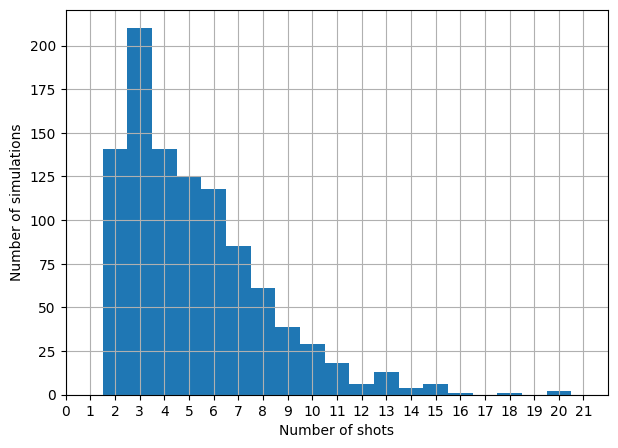

In [11]:
histogram_basketball(scipy_simulations)

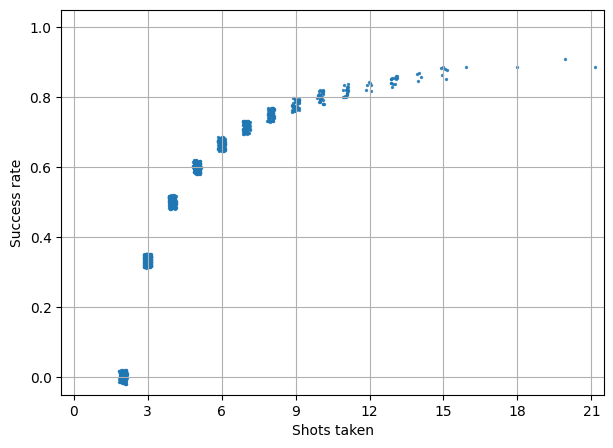

In [12]:
scatter_basketball(scipy_simulations)

## 5.2, Continuous probability simulation

> The logarithms of weights (in pounds) of men in the United States are
> approximately normally distributed with mean 5.13 and standard deviation 0.17;
> women’s log weights are approximately normally distributed with mean 4.96 and
> standard deviation 0.20. Suppose 10 adults selected at random step on an
> elevator with a capacity of 1750 pounds. What is the probability that their
> total weight exceeds this limit?

In [13]:
rng = random.default_rng(seed=seed('Example 5.2'))

In [14]:
def sample_weight() -> float:
    """Sample one US person's weight."""
    return numpy.exp(
        rng.normal(4.96, 0.2)
        if rng.uniform() < 0.5
        else rng.normal(5.13, 0.17)
    )

def exceeds_weight() -> bool:
    total_weight = 0
    for _ in range(10):
        total_weight += sample_weight()
        if total_weight > 1750:
            return True
    return False        

In [15]:
num_sims = 100_000
num_exceeds = sum(1 if exceeds_weight() else 0 for _ in range(num_sims))
exceed_rate = float(num_exceeds) / num_sims
std_err = numpy.sqrt(exceed_rate * (1 - exceed_rate) / num_sims)

print(f'{100 * exceed_rate:0.1f}% +/- {200 * std_err:0.2f}%')
print(f'[{100 * (exceed_rate - 2 * std_err):0.2f}%, {100 * (exceed_rate + 2 * std_err):0.2f}%]')

5.6% +/- 0.15%
[5.43%, 5.72%]


## 5.3, Binomial distribution

> A player takes 10 basketball shots, with a 40% probability of making each
> shot. Assume the outcomes of the shots are independent. 
>
> (a) Write a line of R code to compute the probability that the player makes
> exactly 3 of the 10 shots.
>
> (b) Write an R function to simulate the 10 shots. Loop this function 10,000
> times and check that your simulated probability of making exactly 3 shots is
> close to the exact probability computed in (a).

In [16]:
rng = random.default_rng(seed=seed('Example 5.3'))

In [17]:
official_answer = stats.binom.pmf(3, 10, 0.4)
print(f'Official chance: {100*official_answer:0.1f}%')

Official chance: 21.5%


In [18]:
def hits_three_of_ten() -> bool:
    """Does our shooter hit *exactly* 3 of 10 shots?"""
    hits = 0
    for _ in range(10):
        is_hit = (rng.uniform() < 0.4)
        if is_hit:
            hits += 1
            if hits == 4:
                return False
    return hits == 3

In [19]:
num_sims = 10_000
three_hits = sum(1 if hits_three_of_ten() else 0 for _ in range(num_sims))
three_hits_rate = float(three_hits) / num_sims
std_err = numpy.sqrt(three_hits_rate * (1 - three_hits_rate) / num_sims)
print(f'{100 * three_hits_rate:0.1f}% +/- {200 * std_err:0.2f}%')
print(f'[{100 * (three_hits_rate - 2 * std_err):0.2f}%, {100 * (three_hits_rate + 2 * std_err):0.2f}%]')

21.8% +/- 0.83%
[21.00%, 22.66%]


## 5.4, Demonstration of the Central Limit Theorem

> Let $x = x_1 + \ldots + x_{20}$, the sum of 20 independent uniform(0; 1)
> random variables. In R, create 1000 simulations of $x$ and plot their
> histogram. > What is the normal approximation to this distribution provided by
> the Central Limit Theorem? Overlay a graph of the normal density on top of the
> histogram. Comment on any differences between the histogram and the curve.

In [20]:
rng = random.default_rng(seed=seed('Example 5.4'))

/tmp/ipykernel_24804/2788576766.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['' for _ in ytlabels])


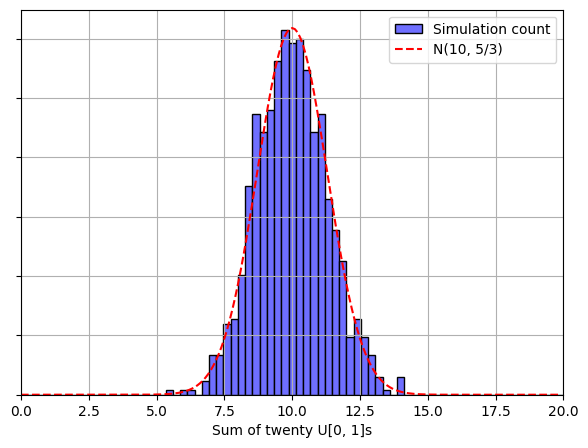

In [21]:
num_sims = 1000
sims = rng.uniform(0, 1, (num_sims, 20)).sum(axis=1)
fig = pyplot.figure(figsize=(7, 5))
ax = fig.gca()
ax.hist(sims, bins=75, range=(0, 20), edgecolor='black', color='#6F6FFF',
        density=True, label='Simulation count')
ax.set_xlabel('Sum of twenty U[0, 1]s')
ax.set_xlim(0, 20)

pmf_xs = numpy.arange(0, 20, 0.1)
pmf_ys = [stats.norm.pdf(xi, loc=10, scale=numpy.sqrt(20/12)) for xi in pmf_xs]
ytlabels = ax.get_yticklabels()
ax.set_yticklabels(['' for _ in ytlabels])
ax.plot(pmf_xs, pmf_ys, 'r--', label='N(10, 5/3)')
ax.legend()
ax.grid()

In [22]:
print("""























""")